In [40]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat, u_darrays
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [41]:
cd ..

/home/ck/pythonWorkspace


In [42]:
OBS = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-40_zeroRain_gt5k_-40thresh_OBSera.p', 'rb'))

In [43]:
print(OBS.keys())

dict_keys(['w650', 'lon', 'pgt30', 'pv925', 'pmean', 'p', 'lat', 'rh925', 'area', 't925', 'month', 'pgt01isvalid', 'u650', 'q650', 'tmin', 'w925', 'v650', 'shear', 'div925', 'clon', 'div650', 't650', 'v925', 'pv650', 'q925', 'u925', 'tmean', 'pmax', 'year', 'hour', 't', 'rh650', 'clat'])


In [44]:
dic = OBS

pp = np.array(dic['pmax'])
sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
umin = np.array(dic['u650'])
umax = np.array(dic['u925'])
qq = np.array(dic['q925']) 
rh = np.array(dic['rh925']) 
tt = np.array(dic['tmin'])
ttm = np.array(dic['tmean'])
month = np.array(dic['month'])
area = np.array(dic['area'])
lat = np.array(dic['clat'])
lon = np.array(dic['clon'])

obs_pcp = {
    'prcp' : pp,
    'u650' : umin,
    'u925' : umax,
    'q925' : qq*1000,
    'rhtot' : rh,
    'shear' : sh*-1,
    'month' : month,
    'area' : area*7.7**2,
    'tmin' : tt,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
obs = pd.DataFrame(obs_pcp)

In [55]:
def get_ERA(era, indic, clim=False):

    dic = {}
    dic['u925'] = []
    dic['u650'] = []
    dic['q925'] = []
    dic['q700'] = []
    dic['rh925'] = []
    
    for id, date in enumerate(indic.date):
        
        if clim == True:
            getera =np.where((era['time.month']==indic.month[id]) & (era['time.year']==indic.year[id]))

        else:
            getera =np.where((era['time.day']==(indic['date'])[id].day) & (era['time.month']==indic.month[id]) & (era['time.year']==indic.year[id]))

        try:
            era_day = era.isel(time=int(getera[0]))
        except TypeError:
            print('Era missing')
            for k in dic.keys():
                dic[k].append(np.nan)

            continue

        elat = indic.clat[id]
        elon = indic.clon[id]
        dic['u925'].append(float(era_day['u'].sel(latitude=elat, longitude=elon, level=925, method='nearest').values))
        dic['u650'].append(float(era_day['u'].sel(latitude=elat, longitude=elon, level=650, method='nearest').values))
        dic['q925'].append(float(era_day['q'].sel(latitude=elat, longitude=elon, level=925, method='nearest').values))
        dic['q700'].append(float(era_day['q'].sel(latitude=elat, longitude=elon, level=700, method='nearest').values))
        dic['rh925'].append(float(era_day['r'].sel(latitude=elat, longitude=elon, level=925, method='nearest').values))

    return dic

In [56]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))
pdf = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12))
pdf = pdf.dropna()

ttg = np.array(pdf.tmin, dtype=float)
ttm = np.array(pdf.tmean, dtype=float)
month = pdf.month.values
area = pdf.area.values
area70 = np.array(pdf['70area'], dtype=int)
lat = pdf.clat.values
lon = pdf.clon.values

In [ ]:
era = xr.open_dataset(cnst.ERA_DAILY_PL12UTC)
era = u_darrays.flip_lat(era)

In [ ]:
era_out = get_ERA(era, pdf)
pkl.dump(era_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA_qhistogram.p', 'wb'))

Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing
Era missing


In [26]:
era_out = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA_qhistogram.p', 'rb'))

In [37]:
era_out.keys()

dict_keys(['rhlow', 'rhmid', 'u650', 'q925', 'u925', 'qlow', 'q700', 'qmid', 'rh925'])

In [28]:
e_u650 = np.array(era_out['u650'])
e_u925 = np.array(era_out['u925'])
e_q925 = np.array(era_out['q925'])
e_q700 = np.array(era_out['q700'])
e_rh925 = np.array(era_out['rh925'])

In [29]:
dic = {
    'u650' : e_u650,
    'u925' : e_u925,
    'q925' : e_q925*1000,
    'q700' : e_q700*1000,
    'rh925' : e_rh925,
    'shear' : (e_u650-e_u925)*-1,
    'month' : month,
    'area' : area*7.7**2,
    'tmin' : ttg,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
ds = pd.DataFrame(dic)

ValueError: arrays must all be same length

In [28]:
ds = ds.dropna()

In [29]:
pos1 = (ds.month<=5)  & (ds.u650<0) & (ds.area>=5000)
pos2 = (ds.month>=9)  & (ds.u650<0) & (ds.area>=5000)

opos1 = (obs.month==3)  & (obs.u650<0) & (obs.area>=1000)
opos2 = (obs.month==10)  & (obs.u650<0) & (obs.area>=1000)

In [31]:
oposi = (obs.u650<0) & (obs.area>=5000) & (obs.prcp>=1) & ((obs.month>=9) | (obs.month<=5))

In [33]:
ds_march = ds[pos1]
ds_oct = ds[pos2]
obs_march = obs[opos1]
obs_oct = obs[opos2]

In [34]:
obsp = obs[oposi]

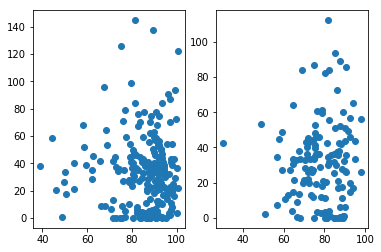

In [35]:
f = plt.figure()
ax = f.add_subplot(121)
plt.scatter(obs_oct.rhtot, obs_oct.prcp)
#plt.xlim(0,150)

ax = f.add_subplot(122)
plt.scatter(obs_march.rhtot, obs_march.prcp)
#plt.xlim(0,150)
#ax.set_ylim(0,130)

(array([ 9.,  5., 10., 12.,  9., 19.,  7., 10.,  5.,  6.,  3.,  3.,  0.,
         1.,  0.,  3.,  3.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([ 10.        ,  14.66666667,  19.33333333,  24.        ,
         28.66666667,  33.33333333,  38.        ,  42.66666667,
         47.33333333,  52.        ,  56.66666667,  61.33333333,
         66.        ,  70.66666667,  75.33333333,  80.        ,
         84.66666667,  89.33333333,  94.        ,  98.66666667,
        103.33333333, 108.        , 112.66666667, 117.33333333,
        122.        , 126.66666667, 131.33333333, 136.        ,
        140.66666667, 145.33333333, 150.        ]),
 <a list of 30 Patch objects>)

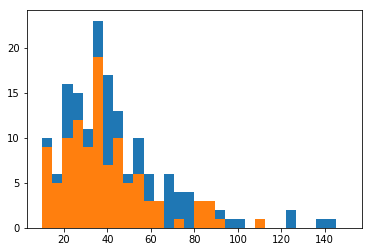

In [37]:
plt.hist(obs_oct.prcp, bins=30, range=(10,150))
plt.hist(obs_march.prcp, bins=30, range=(10,150))

In [38]:
print(np.percentile(obs_march.prcp,90))
print(np.percentile(obs_oct.prcp,90))

59.906640237483174
68.74397024805508


In [54]:
#March oct test
inputs = ds
pos_march = (inputs.month==3)  & (inputs.u650<0) & (inputs.area>=10000) #& (ds.q925>=12.5)
pos_oct = (inputs.month==10)  & (inputs.u650<0) & (inputs.area>=10000)
dss_march = inputs[pos_march]
dss_oct = inputs[pos_oct]

In [55]:
print(np.mean(dss_march.rhtot))
print(np.mean(dss_oct.rhtot))

73.16757411197747
80.23220234162264


In [56]:
dss_oct.lat.min()

4.5149993896484375

(array([1.000e+00, 1.000e+00, 4.000e+00, 2.900e+01, 2.940e+02, 1.104e+03,
       1.035e+03, 3.870e+02, 9.000e+01, 1.300e+01]), array([0.90334968, 0.96650496, 1.02966024, 1.09281552, 1.1559708 ,
       1.21912608, 1.28228136, 1.34543664, 1.40859193, 1.47174721,
       1.53490249]), <a list of 10 Patch objects>)
[6.233951926231384, 13.53812325000763, 6.093698740005493, 7.469309425045704, 7.603864745067458, 8.192521110084668, 8.237010228307692, 8.681762088945698, 8.033670631775426, 9.637586814661821]
(array([ 12.,  22.,  93., 326., 766., 802., 474., 185.,  40.,  19.]), array([1.0060723 , 1.06520529, 1.12433827, 1.18347125, 1.24260423,
       1.30173721, 1.36087019, 1.42000317, 1.47913615, 1.53826913,
       1.59740211]), <a list of 10 Patch objects>)


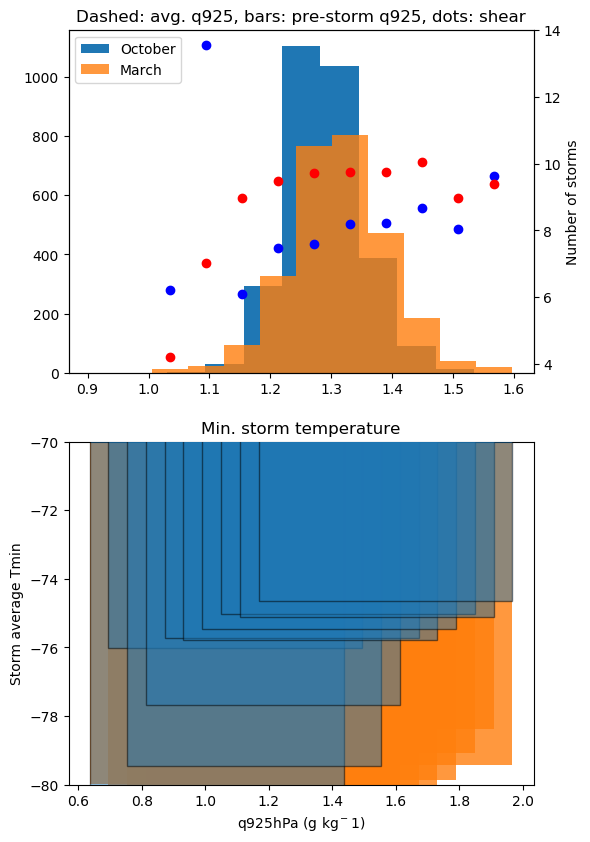

In [57]:
f = plt.figure(figsize=(6,10), dpi=100)
ax = f.add_subplot(211)

Ho = plt.hist(dss_oct.q925/dss_oct.qtot, label='October', bins=10)
bins = Ho[1]
binmid = bins[1::]-((bins[1::]-bins[0:-1])/2)
print(Ho)
#plt.vlines(15.048924, 0, 1900, 'b', linestyle='dashed')
shears_oct = []
tmin_oct = []
for ids, qs in enumerate(bins[0:-1]):
    pos = (dss_oct.q925/dss_oct.qtot>=qs) & (dss_oct.q925/dss_oct.qtot<bins[ids+1])
    pick = dss_oct.where(pos)
    shears_oct.append(np.mean(pick.shear))
    tmin_oct.append(np.mean(pick.tmin))
print(shears_oct)
  
Hm = plt.hist(dss_march.q925/dss_march.qtot, label='March', alpha=0.8, bins=10)
print(Hm)
#plt.vlines(15.146461,0, 1900,'r', linestyle='dashed')
bins = Hm[1]
binmid = bins[1::]-((bins[1::]-bins[0:-1])/2)
shears_march = []
tmin_march = []
for ids, qs in enumerate(bins[0:-1]):
    pos = (dss_march.q925/dss_march.qtot>=qs) & (dss_march.q925/dss_march.qtot<bins[ids+1])
    pick = dss_march.where(pos)
    shears_march.append(np.mean(pick.shear))
    tmin_march.append(np.mean(pick.tmin))

ax1 = ax.twinx()
ax1.plot(binmid,shears_oct, 'bo') 
ax1.plot(binmid,shears_march, 'ro')


plt.ylabel('Number of storms')
plt.title('Dashed: avg. q925, bars: pre-storm q925, dots: shear')
ax.legend(loc='upper left')


ax = f.add_subplot(212)
plt.title('Min. storm temperature')
plt.bar(binmid,tmin_oct, align='center', zorder=9, edgecolor='k', alpha=0.5)
plt.bar(binmid,tmin_march, alpha=0.8, align='center')
ax.set_xlabel('q925hPa (g kg$^-1$)')
plt.ylim(-80,-70)
plt.ylabel('Storm average Tmin')

plt.savefig(cnst.network_data + 'figs/barplot_storm_avgQ.jpg')

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 40.,  46.,  52.,  58.,  64.,  70.,  76.,  82.,  88.,  94., 100.]), <a list of 10 Patch objects>)
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 40.,  46.,  52.,  58.,  64.,  70.,  76.,  82.,  88.,  94., 100.]), <a list of 10 Patch objects>)


Text(0, 0.5, 'Storm average Tmin')

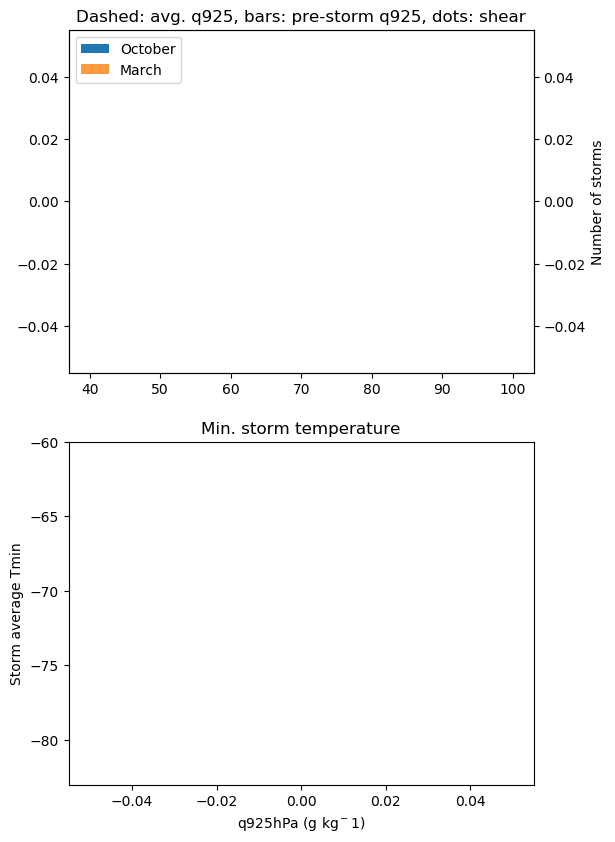

In [58]:
f = plt.figure(figsize=(6,10), dpi=100)
ax = f.add_subplot(211)

Ho = plt.hist(dss_oct.q925, label='October', bins=10, range=(40,100))
bins = Ho[1]
binmid = bins[1::]-((bins[1::]-bins[0:-1])/2)
print(Ho)
#plt.vlines(15.048924, 0, 1900, 'b', linestyle='dashed')
shears_oct = []
tmin_oct = []
for ids, qs in enumerate(bins[0:-1]):
    pos = (dss_oct.q925>=qs) & (dss_oct.q925<bins[ids+1])
    pick = dss_oct.where(pos)
    shears_oct.append(np.mean(pick.u650))
    tmin_oct.append(np.mean(pick.tmin))
print(shears_oct)
  
Hm = plt.hist(dss_march.q925, label='March', alpha=0.8, bins=10, range=(40,100))
print(Hm)
#plt.vlines(15.146461,0, 1900,'r', linestyle='dashed')
bins = Hm[1]
binmid = bins[1::]-((bins[1::]-bins[0:-1])/2)
shears_march = []
tmin_march = []
for ids, qs in enumerate(bins[0:-1]):
    pos = (dss_march.q925>=qs) & (dss_march.q925<bins[ids+1])
    pick = dss_march.where(pos)
    
    shears_march.append(np.mean(pick.u650))
    tmin_march.append(np.mean(pick.tmin))

ax1 = ax.twinx()
ax1.plot(binmid,shears_oct, 'bo') 
ax1.plot(binmid,shears_march, 'ro')


plt.ylabel('Number of storms')
plt.title('Dashed: avg. q925, bars: pre-storm q925, dots: shear')
ax.legend(loc='upper left')


ax = f.add_subplot(212)
plt.title('Min. storm temperature')
plt.bar(binmid,tmin_oct, align='center', zorder=9, edgecolor='k', alpha=0.5)
plt.bar(binmid,tmin_march, alpha=0.8, align='center')
ax.set_xlabel('q925hPa (g kg$^-1$)')
plt.ylim(-83,-60)
plt.ylabel('Storm average Tmin')


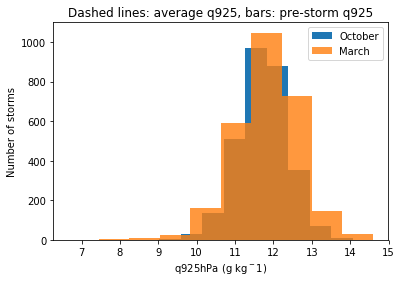

In [61]:
plt.hist(dss_oct.qtot, label='October', bins=10)
#plt.vlines(15.048924, 0, 3000, 'b', linestyle='dashed')

plt.hist(dss_march.qtot, label='March', alpha=0.8, bins=10)
#plt.vlines(15.146461,0, 3000,'r', linestyle='dashed')
plt.xlabel('q925hPa (g kg$^-1$)')
plt.ylabel('Number of storms')
plt.title('Dashed lines: average q925, bars: pre-storm q925')
plt.legend()

pears (0.21497108973521759, 5.3355271468691504e-30)
pears (0.05339571964219884, 0.0036736516022420535)


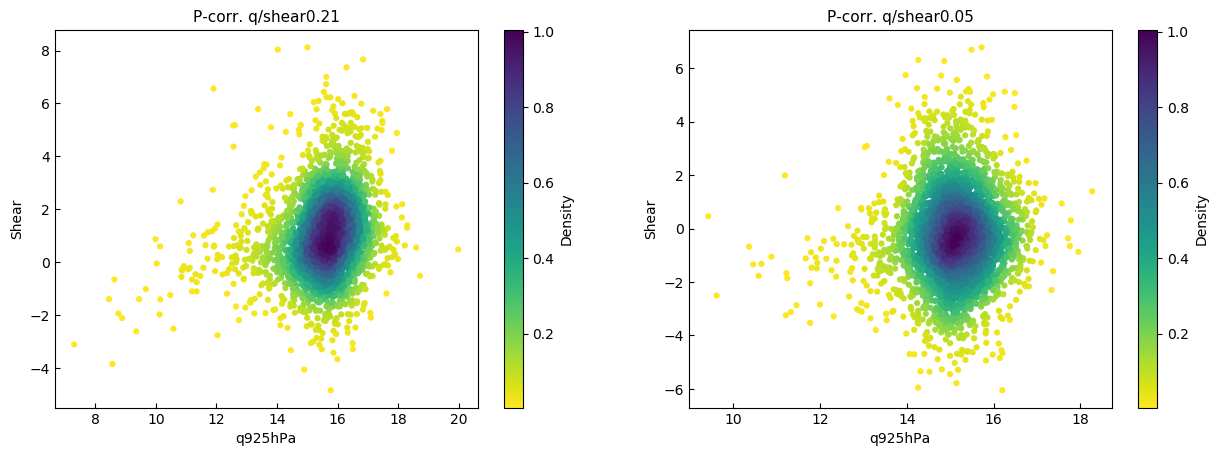

In [60]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

fig = plt.figure(figsize=(15, 5), dpi=100)
cc=11


data1, r1 = density_plot(dss_march.q925, dss_march.u925)

ax1 = fig.add_subplot(121)
mappable = ax1.scatter(dss_march.q925, dss_march.u925, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
#plt.xlim(12,19)
ax1.set_ylabel('Shear')
ax1.set_xlabel('q925hPa')
ax1.set_title('P-corr. q/shear'+str(np.round(r1[0], decimals=2)), fontsize=cc)
ax1.tick_params(direction='in')
cbar = fig.colorbar(mappable)
cbar.set_label('Density')

data1, r1 = density_plot(dss_oct.q925, dss_oct.u925)

ax1 = fig.add_subplot(122)
mappable = ax1.scatter(dss_oct.q925, dss_oct.u925, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
#plt.xlim(12,19)
ax1.set_ylabel('Shear')
ax1.set_xlabel('q925hPa')
ax1.set_title('P-corr. q/shear'+str(np.round(r1[0], decimals=2)), fontsize=cc)
ax1.tick_params(direction='in')
cbar = fig.colorbar(mappable)
cbar.set_label('Density')


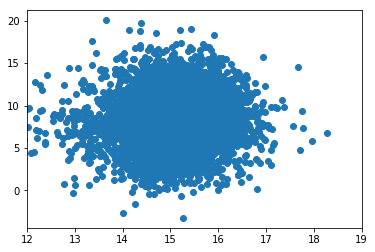

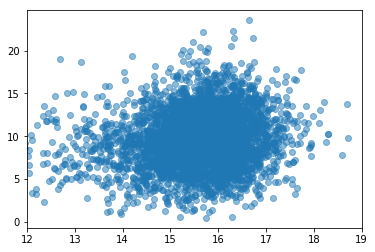

In [591]:
plt.figure()
plt.scatter(dss_oct.q925,dss_oct.shear)
plt.xlim(12,19)
plt.figure()
plt.xlim(12,19)
plt.scatter(dss_march.q925,dss_march.shear, alpha=0.5)

In [593]:
def density_plot(v1,v2,v3):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = u_stat.pcor(v1,v2,v3)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

In [596]:
print('Mean storm q, oct', np.mean(ds_oct.q925))
print('Mean storm q, march', np.mean(ds_march.q925))

Mean storm q, oct 15.026176996778801
Mean storm q, march 15.595371407285636


In [634]:
dsperc_mar, dsp_mar, dsarea_mar, dsval_mar = create_2dhist(ds_march, shearb_march, qbinsb_march)
dsperc_oct, dsp_oct, dsarea_oct, dsval_oct = create_2dhist(ds_oct, shearb_oct, qbinsb_oct)

In [635]:
cp4perc_mar, cp4pr_mar, cp4area_mar, cp4val_mar = create_2dhist(cp4_march, shearc_march, qbinsc_march)
cp4perc_oct, cp4pr_oct, cp4area_oct, cp4val_oct = create_2dhist(cp4_oct, shearc_oct, qbinsc_oct)

In [636]:
cp25perc_mar, pc25pr_mar, cp25area_mar, cp25val_mar = create_2dhist(cp25_march, shear25_march, qbinsc25_march)
cp25perc_oct, pc25pr_oct, cp25area_oct, cp25val_oct = create_2dhist(cp25_oct, shear25_oct, qbinsc25_oct)

In [637]:
cpobsperc, pcobs, obsarea, obsval = create_2dhist_rh(obsp, shear_obsp, qbinso)
cp4perc, pc4, cp4area, cp4val = create_2dhist(cp4p, shear_cp4p, qbinsc)
cp25perc, pc25, cp25area, cp25val = create_2dhist(cp25p, shear_cp25p, qbinsc25)

In [638]:
pcobs.shape

(5, 5)

In [639]:
print(ds_march.shear.mean())
print(ds_march.q925.mean())

10.145094568785044
15.595371407285636


In [640]:
print(ds_oct.shear.mean())
print(ds_oct.q925.mean())

7.6289889958216275
15.026176996778801
